# Importing all the libraries and scripts

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential, losses
import matplotlib.pyplot as plt
import numpy as np
import os

import warnings

warnings.filterwarnings('ignore')

# Helper functions

In [3]:
'''

A function that will receive a tensor dataset and return with
training and validation set split.

'''

def get_train_test_split_tf(ds,
                             train_split = 0.8,
                             val_split = 0.1,
                             shuffle = True,
                             shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds


'''

A function that predictes the class name given the moadel and
the potato image.

'''
def predict(model,img,class_names):

  img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
  img_array = tf.expand_dims(img_array,0)

  prediction = model.predict(img_array)

  predicted_class = class_names[np.argmax(prediction[0])]
  confidence = round(100 * (np.max(prediction[0])),2)

  return predicted_class,confidence

# Model training

In [24]:
# Initializing some values for our model training

file_path = '..'
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 256

In [5]:
# Importing the data from a file path and using tensor for shuffling and batching

dataset = tf.keras.preprocessing.image_dataset_from_directory(file_path + '/data',
                                                              shuffle = True,
                                                              image_size = (IMG_SIZE,IMG_SIZE),
                                                              batch_size = BATCH_SIZE
                                                             )

Found 2152 files belonging to 3 classes.


In [6]:
# Lets see all the class names

class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
# Lets see the length of our dataset

# 68 * 32 <= 2152

len(dataset)

68

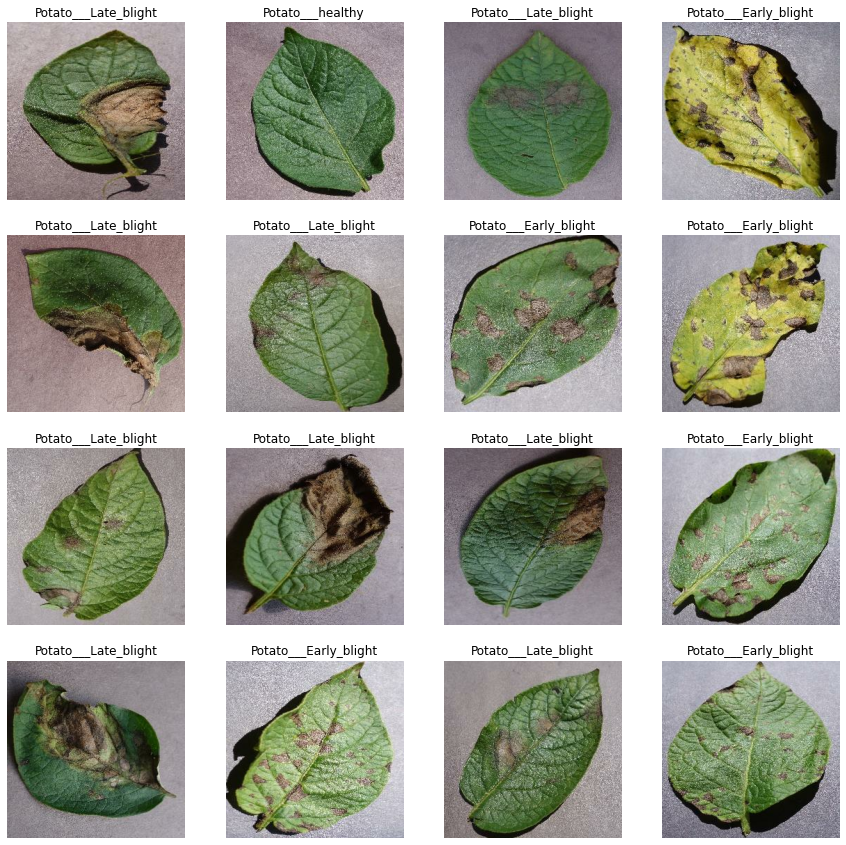

In [8]:
# Lets take the first batch in our dataset and plot the first 16 images in that batch

for img_batch,label_batch in dataset.take(1):
    fig = plt.figure(figsize=(15,15))
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(img_batch[i].numpy().astype('uint'))
        plt.axis('off')

    fig.savefig(file_path + f'/charts/different_potato_images.jpg')


In [9]:
# Train test spliting using our helper function

train_ds,val_ds,test_ds = get_train_test_split_tf(dataset,shuffle = True)

In [10]:
# Checking the length of our train set

len(train_ds)

54

In [11]:
# Checking the length of our validation set

len(val_ds)

6

In [12]:
# Checking the length of our test set

len(test_ds)

8

In [13]:
# For memory and time allocation lets use shuffling and also prefetching

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
# Resizing and rescaling all the images to have a robust model

resize_and_rescale = Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data augmentation since we have limited number of training size

data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
# Lets overcheck the size of our images

for img_batch,label_batch in dataset.take(1):
  batch,img_size,img_size,channels = img_batch.shape
  print(img_batch.shape)

(32, 256, 256, 3)


In [17]:
# CNN model initializing and building

input_shape = (batch,img_size,img_size,channels)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

In [18]:
# Lets see our layers and checkout how many parameters we have

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
# Adding optimizer and loss criterions then compiling our model

model.compile(
    optimizer = 'adam',
    loss = losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [25]:
# Training our model and tracking the results in the history dictionary

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
54/54 [==============================] - 78s 1s/step - loss: 0.1399 - accuracy: 0.9462 - val_loss: 0.1499 - val_accuracy: 0.9375
Epoch 2/20
54/54 [==============================] - 79s 1s/step - loss: 0.0890 - accuracy: 0.9676 - val_loss: 0.2549 - val_accuracy: 0.8854
Epoch 3/20
54/54 [==============================] - 75s 1s/step - loss: 0.1257 - accuracy: 0.9514 - val_loss: 0.0693 - val_accuracy: 0.9740
Epoch 4/20
54/54 [==============================] - 77s 1s/step - loss: 0.0714 - accuracy: 0.9716 - val_loss: 0.1528 - val_accuracy: 0.9375
Epoch 5/20
54/54 [==============================] - 79s 1s/step - loss: 0.0535 - accuracy: 0.9803 - val_loss: 0.1512 - val_accuracy: 0.9531
Epoch 6/20
54/54 [==============================] - 73s 1s/step - loss: 0.0598 - accuracy: 0.9740 - val_loss: 0.5526 - val_accuracy: 0.8333
Epoch 7/20
54/54 [==============================] - 73s 1s/step - loss: 0.1196 - accuracy: 0.9589 - val_loss: 0.1886 - val_accuracy: 0.9115
Epoch 8/20
54/54 [==

In [27]:
# Lets see our history dictionary

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Visualization and model evaluation

In [28]:
'''
Lets take the history components and put them in a different variable
since we need them for visualization later 
'''

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

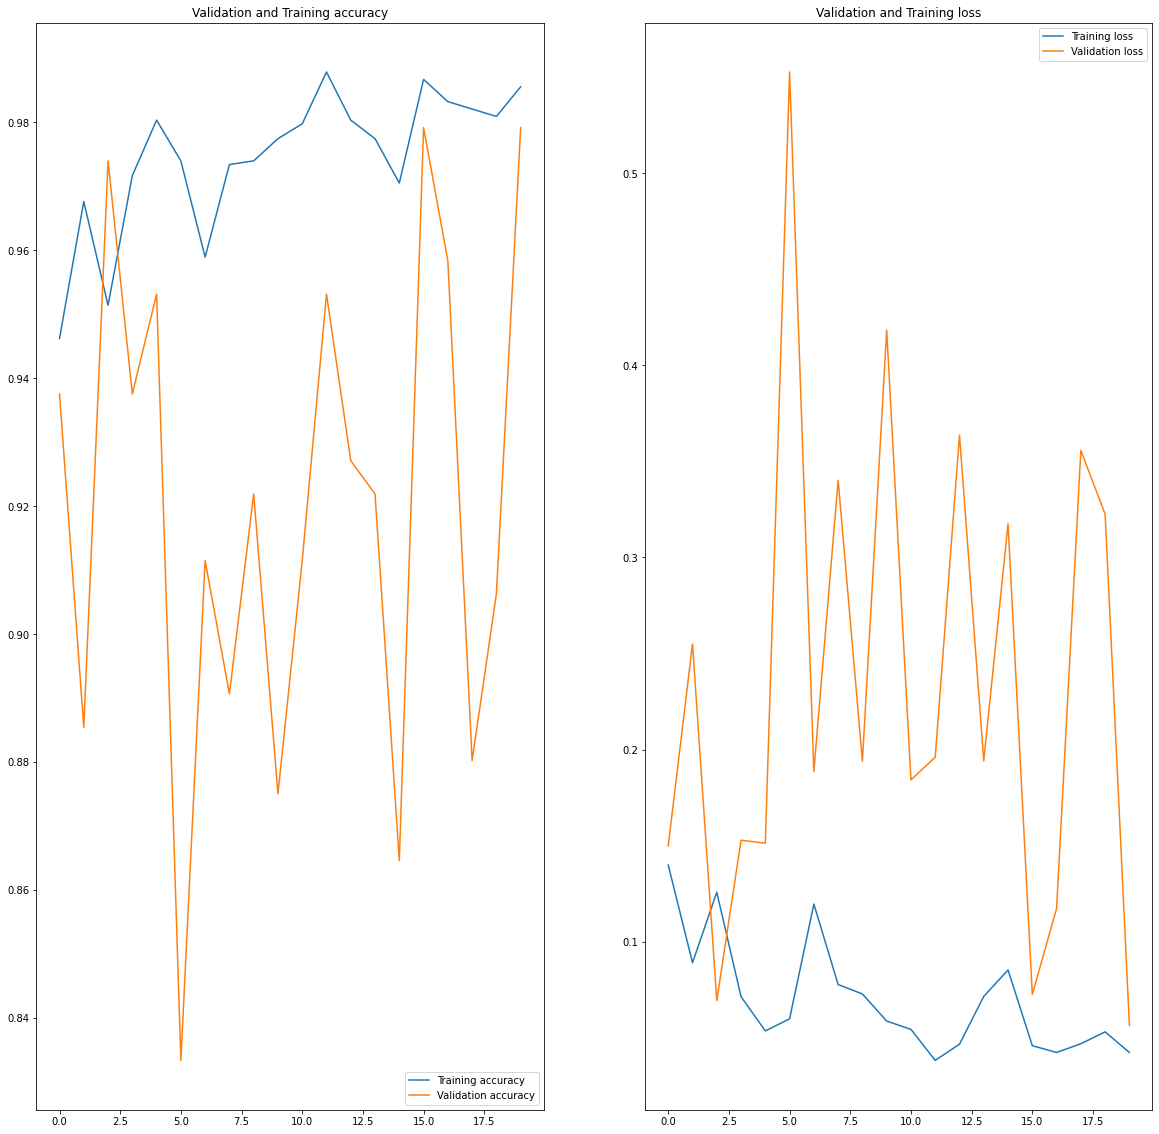

In [30]:
# Plotting the graph of training and validation comparision

fig = plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Validation and Training accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Validation and Training loss')

fig.savefig(file_path + f'/charts/validation_and_training_losses.jpg')

Actual label: Potato___Late_blight
Predicted label: Potato___Late_blight


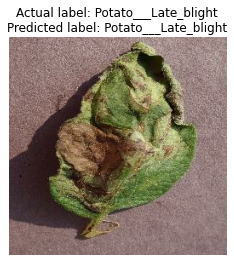

In [31]:
# Lets predict the first image and see the result after plotting

for img_batch,label_batch in train_ds.take(1):

  first_img = img_batch[0].numpy().astype('uint')
  first_label = label_batch[0].numpy()
  batch_prediction = model.predict(img_batch)
  actual = 'Actual label: ' + class_names[first_label]
  predicted = 'Predicted label: ' + class_names[np.argmax(batch_prediction[0])]
  plot_title = actual + '\n' + predicted
  print(actual)
  print(predicted)
  plt.imshow(first_img)
  plt.title(plot_title)
  plt.axis('off')

  plt.savefig(file_path + f'/charts/single_image_prediction.jpg')

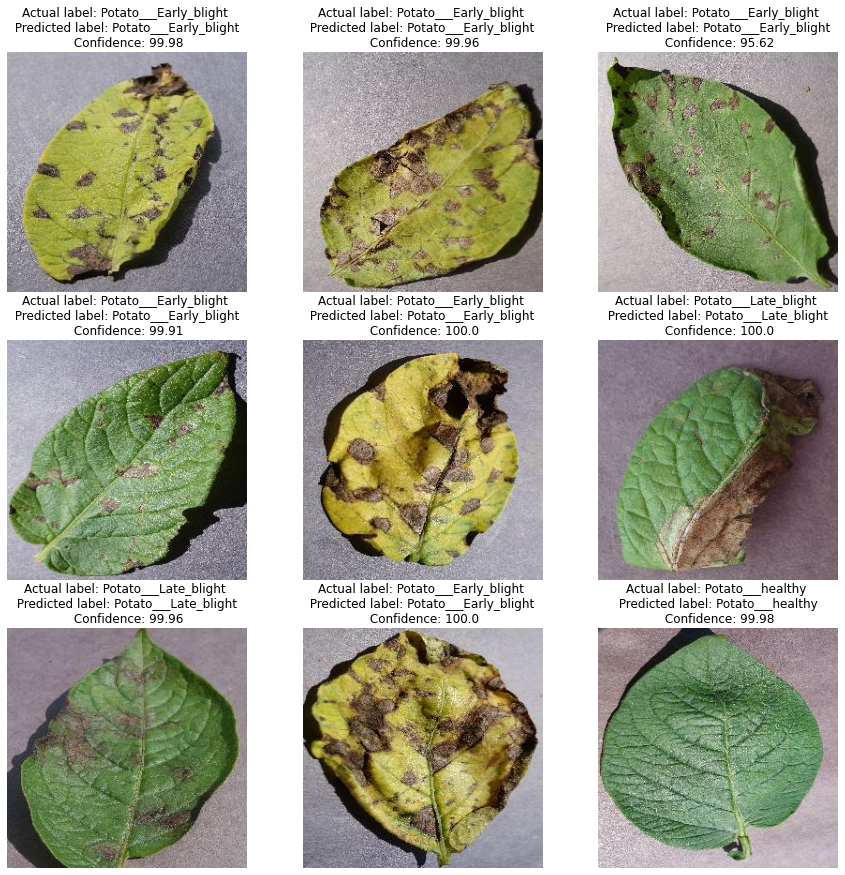

In [32]:
# Lets see prediction of multiple images in our dataset and plot them

plt.figure(figsize=(15,15))

for image_batch,labels_batch in dataset.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint'))

    predicted_class, confidence = predict(model,
                                          image_batch[i],
                                          class_names
                                          )
    
    plt.title('Actual label: {} \n Predicted label: {} \n Confidence: {}'.format(
        class_names[labels_batch[i].numpy()],
        predicted_class,
        confidence
    ))

    plt.axis('off')

    fig.savefig(file_path + f'/charts/multiple_images_prediction.jpg')

In [34]:
# Evaluating the overall accuracy of our model using our test dataset

scores = model.evaluate(test_ds)
print('Total loss is: ', round(scores[0],4))
print('Accuracy of the model is: ', round(scores[1]*100,2), '%')

8/8 [==============================] - 2s 214ms/step - loss: 0.0207 - accuracy: 0.9961
Total loss is:  0.0207
Accuracy of the model is:  99.61 %


# Saving the model 

In [40]:
model_version = max([int(i) for i in os.listdir(file_path + '/models') + [0]]) + 1
model.save(file_path + f'/models/{model_version}')

INFO:tensorflow:Assets written to: ../models/3\assets


In [42]:
os.listdir(file_path + '/models')

['1', '2', '3']